# 주택 가격 예측: 회귀 문제

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [9]:
train_targets[0]

15.2

## 데이터 전처리
특성들의 평균을 빼고 표준 편차로 나누어서 스케일이 다른 데이터들을 정규화 해줌

In [10]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

##  모델 구성
회귀의 출력 값의 범위를 제한하지않게 활성화 함수를 가지지않음


In [11]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(optimizer='rmsprop',
                 loss='mse',
                 metrics=['mae'])
    return model

## K-겹 검증을 사용한 훈련 검증(K-fold cross-validation)

In [22]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [23]:
all_scores

[2.6429460591608933, 3.202428704441184, 3.1008033799653005, 3.8542609427234913]

In [24]:
np.mean(all_scores)

3.200109771572717

## 각 폴드에서 검증 점수를 로그에 저장하기

In [13]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [14]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## 검증 점수 그래프

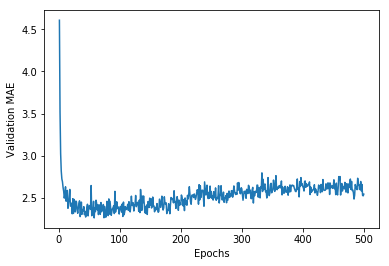

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

그래프의 범위가 크고 변동이 심하다
- 곡선의 다른 부분과 스케일 차이가 큰 첫 10포인트를 제외
- 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동 평균(exponential moving average)으로 대체

### 지수 평균 이동
시계열 데이터를 부드럽게 만드는 기법  
이동 평균에 factor를 곱하고 현재 포인트에 (1 - factor)를 곱해 합산

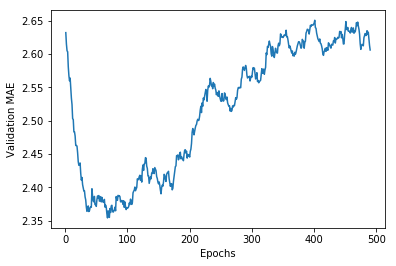

In [21]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [22]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 382us/step


In [23]:
test_mae_score

2.978092455396465

## 정리
- 회귀는 분류에서 사용했던 것과는 다른 손실 함수를 사용
- 평균 제곱 오차(MSE)는 회귀에서 자주 사용되는 손실 함수
- 회귀는 분류에서 사용했던 것과는 다른 평가 지표를 사용(정확도 개념을 사용하지 않음)
- 일반적으로 평균 절대 오차(MAE)를 사용
- 입력 데이터의 특성이 서로 다른 범위를 가지면 전처리 단계에서 각 특성을 개별적으로 스케일 조정 해야함
- 데이터가 적다면 K-fold cross-validation이 신뢰할 수 있는 모델 평가 방법
- 데이터가 적다면 과대 적합을 피하기 위해 은닉 층의 수를 줄인 모델이 좋음(1~2개)